# Pink Buckle Barrel Racing - Stallion Analysis


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

In [4]:
#read in results files
pbf_18 = pd.read_csv('./CSV_Analysis/2018_Futurity')
pbf_19 = pd.read_csv('./CSV_Analysis/2019_Futurity')
pbf_20 = pd.read_csv('./CSV_Analysis/2020_Futurity')

In [5]:
'''Payouts are based on Divisions which are a set time period off the fastest time.  This is called a D.  
We will assign a D to each horse per run for each year.  Later this will be helpful to see if any particular sire's offspring
are more likely to be in any particular division, we will also allocate the first 20 horses in both Ds as money winners per the curtent payout format'''

def AssignDs(df, colstring1, new_col_name):
    '''
    assign D's based on division split, and give the first 20 horses in each D the status of "Money Winner"
    Input: df = Dataframe, 
    colstring1 = String - the time column on the data frame to be placing D's in.
    new_col_name = String - the column name the Ds will be placed in
    output: adds column placeing horse in 1D or 2D
    '''
    D_split = 0.75 # D second split for the PB futurity and Derby
    
    df[new_col_name]= np.where(df[colstring1] > (df[colstring1].min()+D_split), 2, 1)
    
    place_col_name = colstring1 +' Place' #create a value to pull the money winners by placing
    df['Money_Winner'] = np.where(df[place_col_name]<= 20, 1,0) #calls out money winners in 1D
    df.sort_values(colstring1, inplace = True) #sort so we can call the 2D $ winner index  
    two_d = df[df[new_col_name] > 1].index[0] #get the next 20 places, 
    df.iloc[two_d:(two_d+19),df.columns.get_loc('Money_Winner')] = 1 #assign 1 for money winner
    return df
    

In [6]:
# Denote which horses won money and which D (industry slang for division) they placed in
pbf_18 = AssignDs(pbf_18, '1st Go', '1stGoD')
pbf_19 = AssignDs(pbf_19, '1st Go', '1stGoD')
pbf_20 = AssignDs(pbf_20, '1st Go', '1stGoD')
pbf_18 = AssignDs(pbf_18, '2nd Go', '2ndGoD')
pbf_19 = AssignDs(pbf_19, '2nd Go', '2ndGoD')
pbf_20 = AssignDs(pbf_20, '2nd Go', '2ndGoD')

In [7]:
#Concatenate all 3 years results into one dataframe
pbf = pd.concat([pbf_18, pbf_19,pbf_20]).drop(columns = ['Unnamed: 0','#'])
pbf['Sire'] = pbf['Sire'].str.upper() # move all words to upper case to join with 2021 stud fee info from Qstallions.com

display(pbf.head())
display(pbf.columns)

,1st Go Place,Horse,Age,Color,Sex,Sire,Dam,Dam's Sire,Rider,1st Go,2nd Go Place,2nd Go,1stGoD,Money_Winner,2ndGoD
59,63.0,Tee It Up In My Sox,2014.0,Chestnut,Mare,BHR FRENCHIES SOCKS,BA Tee It Up Ta Fame,Tee It Up In My Sox,Lacey Harmon,22.229,1.0,16.779,2,1,1
3,4.0,Jets Heart N Soul,2014.0,Chestnut,Gelding,BLAZIN JETOLENA,Mistys Dash of Fame,Dash Ta Fame,Jolene Montgomery,16.988,2.0,16.818,1,1,1
5,6.0,High Cotton Lane,2014.0,Chestnut,Stallion,THE GOODBYE LANE,HMB Soon Tobe Famous,Dash Ta Fame,Paige Jones,17.021,3.0,16.829,1,1,1
12,13.0,Smooth Movin Guy,2014.0,Buckskin,Gelding,A SMOOTH GUY,Full A Irish Whiskey,Paddys Irish Whiskey,Dustin Angelle,17.305,4.0,16.838,1,1,1
0,1.0,French Goodbye,2014.0,Palomino,Gelding,THE GOODBYE LANE,Two Fools Gold,Frenchmans Guy,Vauna Walker,16.567,5.0,16.936,1,1,1


Index(['1st Go Place', 'Horse', 'Age', 'Color', 'Sex', 'Sire', 'Dam',
       'Dam's Sire', 'Rider', '1st Go', '2nd Go Place', '2nd Go', '1stGoD',
       'Money_Winner', '2ndGoD'],
      dtype='object')

In [8]:
df = pbf.pivot_table(
    index = ['Sire','Horse'],
    values = ['1st Go','2nd Go','1st Go Place', '2nd Go Place','1stGoD','2ndGoD','Money_Winner'] 
)


df['1D_Round']=np.where(df['1stGoD'] == 1,1,0) + np.where(df['2ndGoD']==1,1,0) #assigns a value of 1 for each run a horse had <.75 seconds off the fastest time in their year

df['1D_Horse'] =  np.where(df['1D_Round']>=1, 1,0)

'''Tipped barrels were considered no time at this event and assigned a time of 999.00 for the round. 
Including this in the average will unfairly weight the times in favor of those whose offspring did not tip a barrel.
This should not fault the horse as it could easily be rider error.  Being the results have no way of indicating a horse did not make a run 
and took a no time or if they tipped all 3 barrels, no times were not included in the average. 
    '''
    
df['Tipped'] = (df[df == 999.000].sum(axis = 1))

df.replace(to_replace = {'Tipped': {999.0 : 1, 1998.0 : 2}}, inplace = True)
totals = df.groupby(['Sire']).sum() # calculate sum of statistics for sires

siredata = df.groupby(['Sire']).mean()
siredata['total_offspring'] = df.groupby(['Sire']).size() 
#remove 999.00 to become nan so they aren't included in the average time
(df.replace(to_replace =  {999.0 :np.nan}, inplace = True)) 
df = df.dropna(subset=['1st Go', '2nd Go']) #remove any horse that had no time for both go's  The horse may not have competed at all. 
df['Average'] = df['1st Go']+df['2nd Go']
display(df)

siredata.head(30)
totals.head()

1st Go  1st Go Place  1stGoD  2nd Go  \
Sire            Horse                                                         
A SMOOTH GUY    A Smart Guy            17.446          30.0     1.0  17.495   
                A Smooth Flit          18.495         126.0     2.0  23.143   
                A Smooth Hula Queen    18.566         116.0     2.0  18.501   
                A Smooth Movin Lucy    18.132          97.0     2.0  18.258   
                A Smooth Twister       18.215          50.0     2.0  18.147   
...                                       ...           ...     ...     ...   
TRES SEIS       Tres N Firewater       18.186         104.0     2.0  17.956   
                Tufferenell            22.381         160.0     2.0  22.147   
                TwoBigFourMyBritches   17.520          33.0     1.0  17.393   
WINNERS VERSION Lil Famous Winner      18.238         111.0     2.0  18.302   
                The Right Version      17.102           3.0     1.0  17.511   

                                       2nd Go Place  2ndGoD  Money_Winner  \
Sire            Horse                                                       
A SMOOTH GUY    A Smart Guy                    25.0     1.0             0   
                A Smooth Flit                 168.0     2.0             1   
                A Smooth Hula Queen           111.0     2.0             0   
                A Smooth Movin Lucy           114.0     2.0             0   
                A Smooth Twister               48.0     2.0             0   
...                                             ...     ...           ...   
TRES SEIS       Tres N Firewater               87.0     2.0             0   
                Tufferenell                   151.0     2.0             0   
                TwoBigFourMyBritches           17.0     1.0             1   
WINNERS VERSION Lil Famous Winner             116.0     2.0             0   
                The Right Version              27.0     1.0             0   

                                       1D_Round  1D_Horse  Tipped  Average  
Sire            Horse                                                       
A SMOOTH GUY    A Smart Guy                   2         1     0.0   34.941  
                A Smooth Flit                 0         0     0.0   41.638  
                A Smooth Hula Queen           0         0     0.0   37.067  
                A Smooth Movin Lucy           0         0     0.0   36.390  
                A Smooth Twister              0         0     0.0   36.362  
...                                         ...       ...     ...      ...  
TRES SEIS       Tres N Firewater              0         0     0.0   36.142  
                Tufferenell                   0         0     0.0   44.528  
                TwoBigFourMyBritches          2         1     0.0   34.913  
WINNERS VERSION Lil Famous Winner             0         0     0.0   36.540  
                The Right Version             2         1     0.0   34.613  

[394 rows x 11 columns]

,1st Go,1st Go Place,1stGoD,2nd Go,2nd Go Place,2ndGoD,Money_Winner,1D_Round,1D_Horse,Tipped
Sire,,,,,,,,,,
A SMOOTH GUY,1584.031,2826.0,56.0,1589.506,2937.0,58.0,5,14,11,2.0
AS GOOD AS NICK GETS,999.000,195.0,2.0,999.000,194.0,2.0,0,0,0,2.0
BHR FRENCHIES SOCKS,1437.548,2040.0,42.5,1432.971,1894.0,39.5,6,13,12,2.0
BLAZIN JETOLENA,3666.910,2947.0,63.0,4687.042,3532.0,68.0,10,25,19,7.0
BORN TA BE FAMOUS,224.076,1114.0,20.0,1194.926,1012.0,21.0,1,3,2,1.0


In [9]:
#move totals to the dataframe of average times
siredata['Total_no-times'] = totals['Tipped']
siredata['1D_Horse'] = totals['1D_Horse']
siredata['Money_Winner'] = totals['Money_Winner']

#caluclates the sum of the (average 1st Go and 2nd Go for all offspring removing for 999.00
siredata['Adj Average_Time'] = ((df.groupby(['Sire']).mean()).loc[:,['1st Go','2nd Go']]).sum(axis = 1) 
#average placing is considered the total of the first and second go.  I chose to add the average of the first go, and second go for each sire to get this number.
siredata['Adj Average_placing'] = ((df.groupby(['Sire']).mean()).loc[:,['1st Go Place','2nd Go Place']]).mean(axis = 1)

# 1st Go, 2nd Go and average with all 999.00 included

siredata['Average_Time'] = (siredata.loc[:,['1st Go','2nd Go']]).sum(axis = 1) 
siredata['Average_placing'] = (siredata.loc[:,['1st Go Place','2nd Go Place']]).mean(axis = 1)

siredata.rename(columns = {'Tipped':'Normalized_penalties'}, inplace = True)
siredata.sort_values(by = ['Adj Average_Time', 'Total_no-times'] ,ascending=True, inplace=True)


siredata['pct1D']= 100*(siredata['1D_Horse']/siredata['total_offspring']) # calculate percentage of offspring in the 1D
siredata['pctMoneyWinners'] = 100*(siredata['Money_Winner']/siredata['total_offspring']) # calculate percentage of offspring that earned money
siredata.head()

,1st Go,1st Go Place,1stGoD,2nd Go,2nd Go Place,2ndGoD,Money_Winner,1D_Round,1D_Horse,Normalized_penalties,total_offspring,Total_no-times,Adj Average_Time,Adj Average_placing,Average_Time,Average_placing,pct1D,pctMoneyWinners
Sire,,,,,,,,,,,,,,,,,,
DATS A FRENCHMAN,671.942333,114.666667,2.00,671.853667,102.666667,1.666667,0,0.333333,1,1.333333,3,4.0,35.3880,50.00,1343.79600,108.666667,33.333333,0.0
DASH TA FAME,508.300500,51.500000,2.00,17.652500,36.500000,1.500000,1,0.500000,1,0.500000,2,1.0,35.4470,34.00,525.95300,44.000000,50.000000,50.0
WINNERS VERSION,508.335000,127.500000,1.75,508.453250,134.000000,1.750000,0,0.500000,1,1.000000,4,4.0,35.5765,64.25,1016.78825,130.750000,25.000000,0.0
CORONA CARTEL,17.963000,77.000000,2.00,17.655000,49.000000,1.000000,0,1.000000,1,0.000000,1,0.0,35.6180,63.00,35.61800,63.000000,100.000000,0.0
GUYS EYE PAINT,17.875000,75.000000,2.00,18.038000,94.000000,2.000000,0,0.000000,0,0.000000,1,0.0,35.9130,84.50,35.91300,84.500000,0.000000,0.0


<p> Now lets read in the stud fees,  and see if there is any correlation to the placings.  We will also eliminate any sires whose offspring from the 2021 breeding season are no longer eligible for the competition. </p>

In [10]:
df_sires = pd.read_csv('PB_Sires_2021_Fees.csv')
sire_fees=df_sires.iloc[:,[0,5]] #drop columns with information that are not to be used in our anaylisis
df2 = pd.merge(siredata, sire_fees, on = 'Sire', how = 'outer')
df2.columns

Index(['Sire', '1st Go', '1st Go Place', '1stGoD', '2nd Go', '2nd Go Place',
       '2ndGoD', 'Money_Winner', '1D_Round', '1D_Horse',
       'Normalized_penalties', 'total_offspring', 'Total_no-times',
       'Adj Average_Time', 'Adj Average_placing', 'Average_Time',
       'Average_placing', 'pct1D', 'pctMoneyWinners', 'Fee'],
      dtype='object')

In [11]:

df2 = df2.drop(columns = (['1st Go', '1st Go Place', '1stGoD', '2nd Go', '2nd Go Place',
       '2ndGoD']))

In [12]:

no_entries = (df2['1D_Horse'].isna()).sum() # count the number of 2021 sires who have had not had offspring compete
no_entries
ineligible = (df2['Fee'].isna()).sum()
print('{} Sires have not had any offspring run in the Futurity, {} sires are no longer eligible as of the 2021 breeding season'.format(no_entries, ineligible))

df2['fees_numeric'] = df2[['Fee']].apply(lambda x: str(x[0]).isdigit(), axis=1) # One Famous Eagle does not have Stud fee info available
df2['fees_numeric2'] = (np.where(df2['fees_numeric'] == True, df2['Fee'], np.nan)).astype('float64')
display(df2)
df2.dtypes

27 Sires have not had any offspring run in the Futurity, 12 sires are no longer eligible as of the 2021 breeding season


,Sire,Money_Winner,1D_Round,1D_Horse,Normalized_penalties,total_offspring,Total_no-times,Adj Average_Time,Adj Average_placing,Average_Time,Average_placing,pct1D,pctMoneyWinners,Fee,fees_numeric,fees_numeric2
0,DATS A FRENCHMAN,0.0,0.333333,1.0,1.333333,3.0,4.0,35.3880,50.00,1343.79600,108.666667,33.333333,0.0,3000,True,3000.0
1,DASH TA FAME,1.0,0.500000,1.0,0.500000,2.0,1.0,35.4470,34.00,525.95300,44.000000,50.000000,50.0,NaN,False,NaN
2,WINNERS VERSION,0.0,0.500000,1.0,1.000000,4.0,4.0,35.5765,64.25,1016.78825,130.750000,25.000000,0.0,2500,True,2500.0
3,CORONA CARTEL,0.0,1.000000,1.0,0.000000,1.0,0.0,35.6180,63.00,35.61800,63.000000,100.000000,0.0,NaN,False,NaN
4,GUYS EYE PAINT,0.0,0.000000,0.0,0.000000,1.0,0.0,35.9130,84.50,35.91300,84.500000,0.000000,0.0,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,A GUY WITH PROOF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,True,2500.0
58,COWBOYS CARTEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1750,True,1750.0
59,JUST WINNIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,True,2000.0
60,SHEIK JEAN FLY HTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,True,2000.0


Sire                     object
Money_Winner            float64
1D_Round                float64
1D_Horse                float64
Normalized_penalties    float64
total_offspring         float64
Total_no-times          float64
Adj Average_Time        float64
Adj Average_placing     float64
Average_Time            float64
Average_placing         float64
pct1D                   float64
pctMoneyWinners         float64
Fee                      object
fees_numeric               bool
fees_numeric2           float64
dtype: object

In [13]:
df2 = df2.dropna(subset=['Fee', '1D_Horse'])
df2

,Sire,Money_Winner,1D_Round,1D_Horse,Normalized_penalties,total_offspring,Total_no-times,Adj Average_Time,Adj Average_placing,Average_Time,Average_placing,pct1D,pctMoneyWinners,Fee,fees_numeric,fees_numeric2
0,DATS A FRENCHMAN,0.0,0.333333,1.0,1.333333,3.0,4.0,35.388000,50.000000,1343.796000,108.666667,33.333333,0.000000,3000,True,3000.0
2,WINNERS VERSION,0.0,0.500000,1.0,1.000000,4.0,4.0,35.576500,64.250000,1016.788250,130.750000,25.000000,0.000000,2500,True,2500.0
5,JL SIROCCO,0.0,1.000000,1.0,0.000000,2.0,0.0,36.176500,76.750000,36.176500,76.750000,50.000000,0.000000,3500,True,3500.0
7,STREAKIN BOON DOX,6.0,0.833333,7.0,0.750000,12.0,9.0,36.303429,41.642857,771.996167,93.583333,58.333333,50.000000,2500,True,2500.0
8,NO PRESSURE ON ME,0.0,0.833333,3.0,0.000000,6.0,0.0,36.318833,78.000000,36.318833,78.000000,50.000000,0.000000,2000,True,2000.0
9,PRIME TALENT,2.0,0.500000,3.0,0.500000,8.0,4.0,36.446833,57.083333,526.835125,90.687500,37.500000,25.000000,2000,True,2000.0
12,DASHIN DYNAMO,0.0,0.333333,2.0,0.000000,6.0,0.0,36.739500,81.583333,36.739500,81.583333,33.333333,0.000000,1750,True,1750.0
13,THE GOODBYE LANE,17.0,0.916667,32.0,0.041667,48.0,2.0,36.963457,60.967391,77.781000,62.947917,66.666667,35.416667,6500,True,6500.0
15,SLICK BY DESIGN,23.0,0.704225,35.0,0.084507,71.0,6.0,37.472779,75.764706,120.311958,80.746479,49.295775,32.394366,3000,True,3000.0
16,TRES SEIS,6.0,0.650000,9.0,0.250000,20.0,5.0,37.642765,81.323529,282.888650,96.500000,45.000000,30.000000,9800,True,9800.0


,Sire,Money_Winner,1D_Round,1D_Horse,Normalized_penalties,total_offspring,Total_no-times,Adj Average_Time,Adj Average_placing,Average_Time,Average_placing,pct1D,pctMoneyWinners,Fee,fees_numeric,fees_numeric2
15,SLICK BY DESIGN,23.0,0.704225,35.0,0.084507,71.0,6.0,37.472779,75.764706,120.311958,80.746479,49.295775,32.394366,3000,True,3000.0
13,THE GOODBYE LANE,17.0,0.916667,32.0,0.041667,48.0,2.0,36.963457,60.967391,77.781000,62.947917,66.666667,35.416667,6500,True,6500.0
23,BLAZIN JETOLENA,10.0,0.641026,19.0,0.179487,39.0,7.0,38.356457,74.371429,214.203897,83.064103,48.717949,25.641026,5000,True,5000.0
21,BHR FRENCHIES SOCKS,6.0,0.541667,12.0,0.083333,24.0,2.0,37.935609,78.282609,119.604958,81.958333,50.000000,25.000000,4500,True,4500.0
19,SHAWNE BUG LEO,8.0,0.565217,10.0,0.043478,23.0,1.0,37.867318,74.295455,80.662304,78.043478,43.478261,34.782609,4000,True,4000.0
16,TRES SEIS,6.0,0.650000,9.0,0.250000,20.0,5.0,37.642765,81.323529,282.888650,96.500000,45.000000,30.000000,9800,True,9800.0
18,FIREWATER CANYON,0.0,0.230769,2.0,0.230769,13.0,3.0,37.787091,99.590909,263.880538,109.192308,15.384615,0.000000,2500,True,2500.0
24,IRISH PAY,4.0,0.230769,2.0,0.000000,13.0,0.0,39.298077,86.230769,39.298077,86.230769,15.384615,30.769231,2000,True,2000.0
30,FURYOFTHEWIND,6.0,0.692308,6.0,0.076923,13.0,1.0,40.005583,94.041667,115.228615,97.653846,46.153846,46.153846,4000,True,4000.0
7,STREAKIN BOON DOX,6.0,0.833333,7.0,0.750000,12.0,9.0,36.303429,41.642857,771.996167,93.583333,58.333333,50.000000,2500,True,2500.0


,Sire,Money_Winner,1D_Round,1D_Horse,Normalized_penalties,total_offspring,Total_no-times,Adj Average_Time,Adj Average_placing,Average_Time,Average_placing,pct1D,pctMoneyWinners,Fee,fees_numeric,fees_numeric2
13,THE GOODBYE LANE,17.0,0.916667,32.0,0.041667,48.0,2.0,36.963457,60.967391,77.781000,62.947917,66.666667,35.416667,6500,True,6500.0
7,STREAKIN BOON DOX,6.0,0.833333,7.0,0.750000,12.0,9.0,36.303429,41.642857,771.996167,93.583333,58.333333,50.000000,2500,True,2500.0
5,JL SIROCCO,0.0,1.000000,1.0,0.000000,2.0,0.0,36.176500,76.750000,36.176500,76.750000,50.000000,0.000000,3500,True,3500.0
8,NO PRESSURE ON ME,0.0,0.833333,3.0,0.000000,6.0,0.0,36.318833,78.000000,36.318833,78.000000,50.000000,0.000000,2000,True,2000.0
31,TRAFFIC GUY,1.0,0.500000,3.0,0.333333,6.0,2.0,41.498000,126.750000,366.477833,122.916667,50.000000,16.666667,2500,True,2500.0
21,BHR FRENCHIES SOCKS,6.0,0.541667,12.0,0.083333,24.0,2.0,37.935609,78.282609,119.604958,81.958333,50.000000,25.000000,4500,True,4500.0
15,SLICK BY DESIGN,23.0,0.704225,35.0,0.084507,71.0,6.0,37.472779,75.764706,120.311958,80.746479,49.295775,32.394366,3000,True,3000.0
23,BLAZIN JETOLENA,10.0,0.641026,19.0,0.179487,39.0,7.0,38.356457,74.371429,214.203897,83.064103,48.717949,25.641026,5000,True,5000.0
30,FURYOFTHEWIND,6.0,0.692308,6.0,0.076923,13.0,1.0,40.005583,94.041667,115.228615,97.653846,46.153846,46.153846,4000,True,4000.0
16,TRES SEIS,6.0,0.650000,9.0,0.250000,20.0,5.0,37.642765,81.323529,282.888650,96.500000,45.000000,30.000000,9800,True,9800.0


,Sire,Money_Winner,1D_Round,1D_Horse,Normalized_penalties,total_offspring,Total_no-times,Adj Average_Time,Adj Average_placing,Average_Time,Average_placing,pct1D,pctMoneyWinners,Fee,fees_numeric,fees_numeric2
7,STREAKIN BOON DOX,6.0,0.833333,7.0,0.750000,12.0,9.0,36.303429,41.642857,771.996167,93.583333,58.333333,50.000000,2500,True,2500.0
0,DATS A FRENCHMAN,0.0,0.333333,1.0,1.333333,3.0,4.0,35.388000,50.000000,1343.796000,108.666667,33.333333,0.000000,3000,True,3000.0
9,PRIME TALENT,2.0,0.500000,3.0,0.500000,8.0,4.0,36.446833,57.083333,526.835125,90.687500,37.500000,25.000000,2000,True,2000.0
13,THE GOODBYE LANE,17.0,0.916667,32.0,0.041667,48.0,2.0,36.963457,60.967391,77.781000,62.947917,66.666667,35.416667,6500,True,6500.0
2,WINNERS VERSION,0.0,0.500000,1.0,1.000000,4.0,4.0,35.576500,64.250000,1016.788250,130.750000,25.000000,0.000000,2500,True,2500.0
19,SHAWNE BUG LEO,8.0,0.565217,10.0,0.043478,23.0,1.0,37.867318,74.295455,80.662304,78.043478,43.478261,34.782609,4000,True,4000.0
23,BLAZIN JETOLENA,10.0,0.641026,19.0,0.179487,39.0,7.0,38.356457,74.371429,214.203897,83.064103,48.717949,25.641026,5000,True,5000.0
15,SLICK BY DESIGN,23.0,0.704225,35.0,0.084507,71.0,6.0,37.472779,75.764706,120.311958,80.746479,49.295775,32.394366,3000,True,3000.0
29,PYC PAINT YOUR WAGON,3.0,0.428571,3.0,0.000000,7.0,0.0,39.981571,76.571429,39.981571,76.571429,42.857143,42.857143,6000,True,6000.0
5,JL SIROCCO,0.0,1.000000,1.0,0.000000,2.0,0.0,36.176500,76.750000,36.176500,76.750000,50.000000,0.000000,3500,True,3500.0


,Sire,Money_Winner,1D_Round,1D_Horse,Normalized_penalties,total_offspring,Total_no-times,Adj Average_Time,Adj Average_placing,Average_Time,Average_placing,pct1D,pctMoneyWinners,Fee,fees_numeric,fees_numeric2
15,SLICK BY DESIGN,23.0,0.704225,35.0,0.084507,71.0,6.0,37.472779,75.764706,120.311958,80.746479,49.295775,32.394366,3000,True,3000.0
13,THE GOODBYE LANE,17.0,0.916667,32.0,0.041667,48.0,2.0,36.963457,60.967391,77.781000,62.947917,66.666667,35.416667,6500,True,6500.0
23,BLAZIN JETOLENA,10.0,0.641026,19.0,0.179487,39.0,7.0,38.356457,74.371429,214.203897,83.064103,48.717949,25.641026,5000,True,5000.0
21,BHR FRENCHIES SOCKS,6.0,0.541667,12.0,0.083333,24.0,2.0,37.935609,78.282609,119.604958,81.958333,50.000000,25.000000,4500,True,4500.0
19,SHAWNE BUG LEO,8.0,0.565217,10.0,0.043478,23.0,1.0,37.867318,74.295455,80.662304,78.043478,43.478261,34.782609,4000,True,4000.0
16,TRES SEIS,6.0,0.650000,9.0,0.250000,20.0,5.0,37.642765,81.323529,282.888650,96.500000,45.000000,30.000000,9800,True,9800.0
18,FIREWATER CANYON,0.0,0.230769,2.0,0.230769,13.0,3.0,37.787091,99.590909,263.880538,109.192308,15.384615,0.000000,2500,True,2500.0
24,IRISH PAY,4.0,0.230769,2.0,0.000000,13.0,0.0,39.298077,86.230769,39.298077,86.230769,15.384615,30.769231,2000,True,2000.0
30,FURYOFTHEWIND,6.0,0.692308,6.0,0.076923,13.0,1.0,40.005583,94.041667,115.228615,97.653846,46.153846,46.153846,4000,True,4000.0
7,STREAKIN BOON DOX,6.0,0.833333,7.0,0.750000,12.0,9.0,36.303429,41.642857,771.996167,93.583333,58.333333,50.000000,2500,True,2500.0


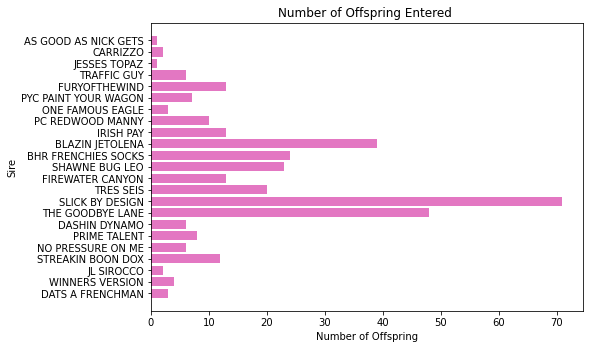

In [29]:
display(df2.sort_values(by = ['total_offspring'],ascending=False))

#Create Plot of total offspring entered
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = df2['Sire']
y = df2['total_offspring']
ax.barh(x,y,color="C6")
ax.set_title("Number of Offspring Entered ")
ax.set_xlabel('Number of Offspring')
ax.set_ylabel("Sire")
plt.show()
#fig.savefig("Number of Offspring Entered.png", dpi=400, bbox_inches="tight")

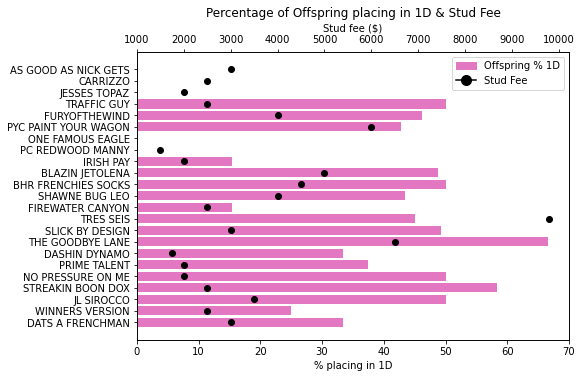

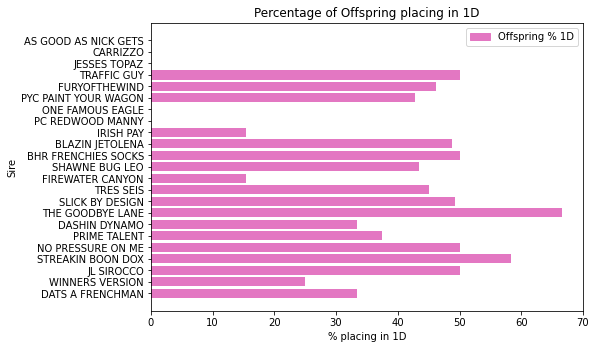

In [17]:
display(df2.sort_values(by = ['pct1D'],ascending=False))
#Create Plot of offspring in 1D
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax2 = ax.twiny()
x = df2['Sire']
y = df2['pct1D']
y2 = df2['fees_numeric2']

ax.barh(x ,y,color="C6")
ax2.scatter(y2,x, color = "k",marker = "o")
plt.xticks([1000,2000,3000,4000,5000,6000,7000,8000,9000,10000])
plt.title("Percentage of Offspring placing in 1D & Stud Fee")
ax2.set_xlabel('Stud fee ($)')
ax.set_xlabel('% placing in 1D')
plt.ylabel("Sire")
pink_patch = mpatches.Patch(color='C6', label='Offspring % 1D')
black_circle = mlines.Line2D([],[], color='k', marker='o',
                          markersize=10, label='Stud Fee')
plt.legend(handles=[pink_patch, black_circle])
plt.show()
fig.savefig("Percentage of Offspring placing in 1D with fee.png", dpi=400, bbox_inches="tight")

#Create Plot of offspring in 1D
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

x = df2['Sire']
y = df2['pct1D']


ax.barh(x ,y,color="C6")
plt.title("Percentage of Offspring placing in 1D")
ax.set_xlabel('% placing in 1D')
plt.ylabel("Sire")
plt.legend(handles=[pink_patch])
plt.show()
fig.savefig("Percentage of Offspring placing in 1D.png", dpi=400, bbox_inches="tight")

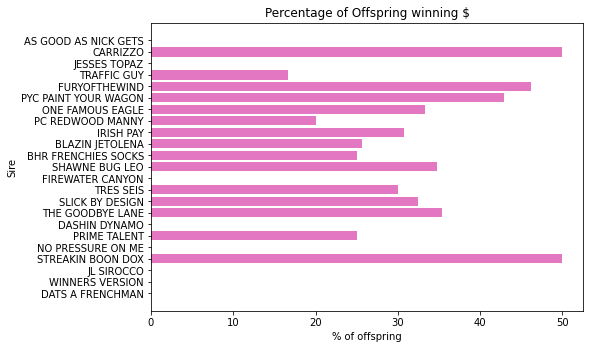

In [18]:
#Create Plot of offspring entered
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = df2['Sire']
y = df2['pctMoneyWinners']
ax.barh(x,y,color="C6")
ax.set_title("Percentage of Offspring winning $")
ax.set_xlabel('% of offspring')
ax.set_ylabel("Sire")
plt.show()
fig.savefig("Percentage of Offspring winning $.png", dpi=400, bbox_inches="tight")

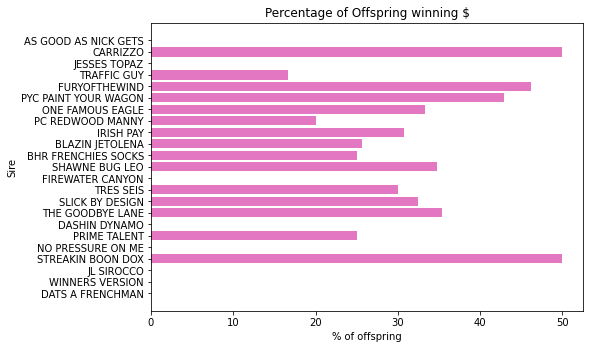

In [23]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = df2['Sire']
y = df2['pctMoneyWinners']
ax.barh(x,y,color="C6")
ax.set_title("Percentage of Offspring winning $")
ax.set_xlabel('% of offspring')
ax.set_ylabel("Sire")
plt.show()

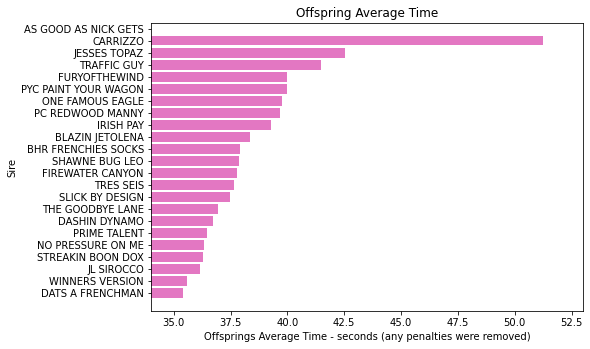

In [19]:
display(df2.sort_values(by = ['Adj Average_placing'],ascending=True))


# Create of offsprings average time 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = df2['Sire']
y = df2['Adj Average_Time']
ax.barh(x,y,color="C6")
ax.set_title("Offspring Average Time")
ax.set_xlabel('Offsprings Average Time - seconds (any penalties were removed)')
ax.set_ylabel("Sire")
plt.xticks
plt.xlim([34, 53])
plt.show()
fig.savefig("Offsprings Average time.png", dpi=400, bbox_inches="tight")

#### Review Correlation of stud Fee with Performance

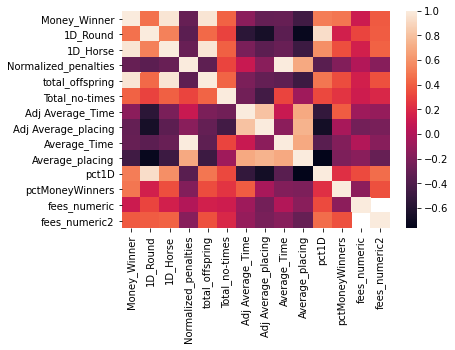

In [20]:
#use calculated statistics - fees numeric2 is the category of interest
# it excludes One Famous Eagle
sns.heatmap(df2.corr());

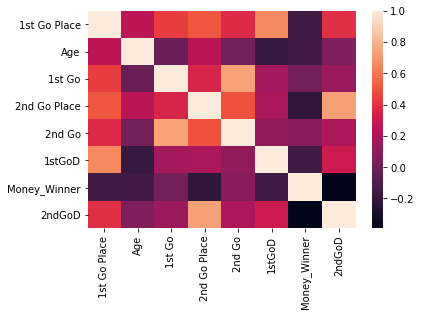

In [21]:
sns.heatmap(pbf.corr());
#appeasing my curiosity to see how performace correlated
#with all horses being included. Stud fees were not included in this

,Money_Winner,1D_Round,1D_Horse,Normalized_penalties,total_offspring,Total_no-times,Adj Average_Time,Adj Average_placing,Average_Time,Average_placing,pct1D,pctMoneyWinners,fees_numeric,fees_numeric2
Money_Winner,1.000000,0.470704,0.968582,-0.299460,0.969860,0.414677,-0.149750,-0.309786,-0.300148,-0.463326,0.518909,0.490565,0.117617,0.390194
1D_Round,0.470704,1.000000,0.532590,-0.345493,0.445214,0.305729,-0.561467,-0.661269,-0.348043,-0.725092,0.937061,0.146481,0.314234,0.396681
1D_Horse,0.968582,0.532590,1.000000,-0.290446,0.972230,0.412976,-0.218836,-0.338633,-0.291522,-0.485197,0.587414,0.346516,0.147200,0.416999
Normalized_penalties,-0.299460,-0.345493,-0.290446,1.000000,-0.332194,0.314612,0.104684,-0.151486,0.999992,0.700863,-0.354159,-0.184993,0.012254,-0.160370
total_offspring,0.969860,0.445214,0.972230,-0.332194,1.000000,0.427165,-0.207444,-0.303713,-0.333152,-0.486727,0.495915,0.341821,0.146587,0.356717
Total_no-times,0.414677,0.305729,0.412976,0.314612,0.427165,1.000000,-0.248168,-0.458845,0.313460,-0.064126,0.330975,0.251992,0.125958,0.186942
Adj Average_Time,-0.149750,-0.561467,-0.218836,0.104684,-0.207444,-0.248168,1.000000,0.807884,0.109853,0.698763,-0.525809,0.397235,-0.072511,-0.104986
Adj Average_placing,-0.309786,-0.661269,-0.338633,-0.151486,-0.303713,-0.458845,0.807884,1.000000,-0.146761,0.742292,-0.669852,-0.029226,-0.242058,-0.226536
Average_Time,-0.300148,-0.348043,-0.291522,0.999992,-0.333152,0.313460,0.109853,-0.146761,1.000000,0.703118,-0.356492,-0.183485,0.011537,-0.160749
Average_placing,-0.463326,-0.725092,-0.485197,0.700863,-0.486727,-0.064126,0.698763,0.742292,0.703118,1.000000,-0.764961,-0.204843,-0.151652,-0.302894


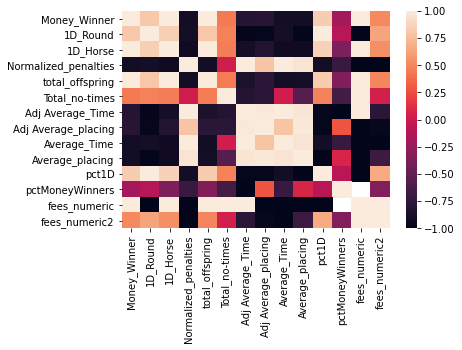

In [30]:
'''display the correlation values calcuated above for df2
 masked out anything with an absolute value of more than 0.25
to help see better relationships in the data'''
    
corrmatrix = df2.corr()
corrmasked = corrmatrix[np.abs(corrmatrix)>=0.25]
sns.heatmap(corrmasked.corr());
display(corrmatrix)

Text(0.5, 1.0, 'Pink Buckle Stud Fees Correlation ')

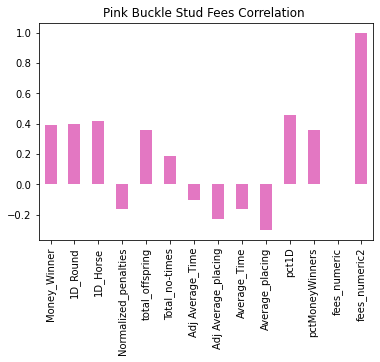

In [37]:
'''Taking a closer look at the fees correlations -
I would expect there to be strong self correlations. There appears to be some
correlation of 1D winners and money winners, but the no times were not invloved in that calculation
I will assume that this is an even lower correlation if we had not removed no-times'''
fee_corr = corrmatrix.fees_numeric2
fee_corr.plot(kind="bar", color="C6")
plt.title("Pink Buckle Stud Fees Correlation ")